In [18]:
import tensorflow as tf
import tensorflow_hub as hub  # for tranfer learning

import matplotlib.pyplot as plt
from IPython.display import Image, display

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


In [2]:
!nvidia-smi

Sun Apr  6 04:11:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2025-04-06 03:35:57--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  16.4MB/s    in 10s     

2025-04-06 03:36:09 (13.5 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2025-04-06 03:36:09--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===============

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [6]:
!ls beans

test  train  validation


In [7]:
# Count of images
!find beans -type f | wc -l

1296


In [10]:
# Count of images in train
!find beans/train -type f | wc -l

1035


In [8]:
# Count of images in test
!find beans/test -type f | wc -l

128


In [9]:
# Count of images in validation
!find beans/validation -type f | wc -l

133


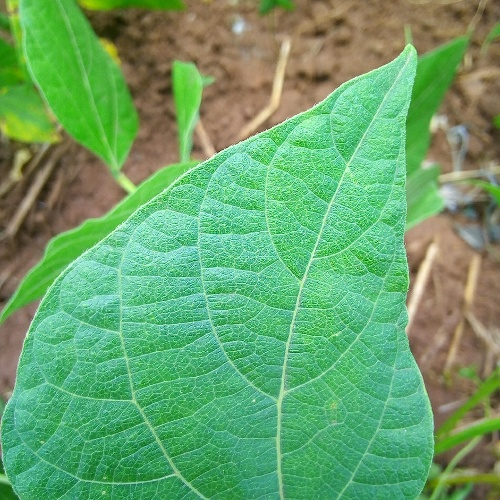

In [13]:
# Displaying an example of healthy leaf from train data
display(Image('beans/train/healthy/healthy_train.0.jpg'))

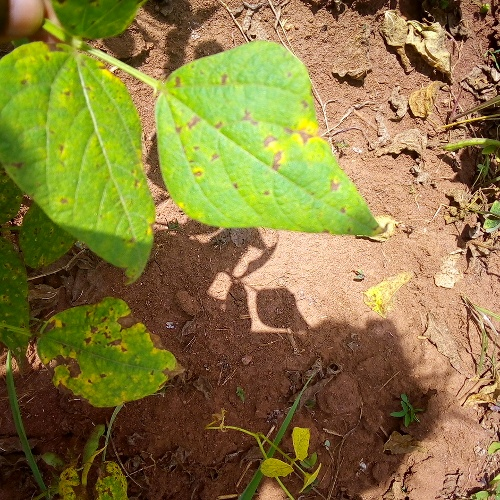

In [19]:
# Displaying an example of angular_leaf_spot leaf from train data
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg'))

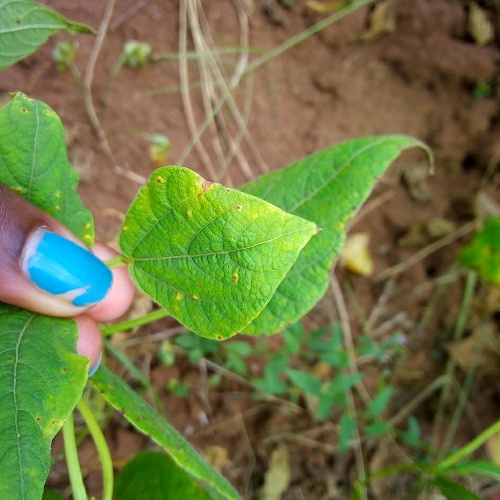

In [18]:
# Displaying an example of bean rust leaf from train data
display(Image('beans/train/bean_rust/bean_rust_train.0.jpg'))

In [19]:
# Constants setting
batch_size = 128
# Make sure to match the image size to match your pre-trained model from tensorflow hub
img_height = 224
img_width = 224

In [20]:
# Training split of the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
                                                               seed = 111,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 1034 files belonging to 3 classes.


In [21]:
# Test split of the data
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
                                                               seed = 111,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [22]:
# Validation split of the data
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
                                                               seed = 111,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [23]:
# Checking shape of the tensor
# Includes: batch_size, img_height, img_width, No. of Channels)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [24]:
# Storing class names
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


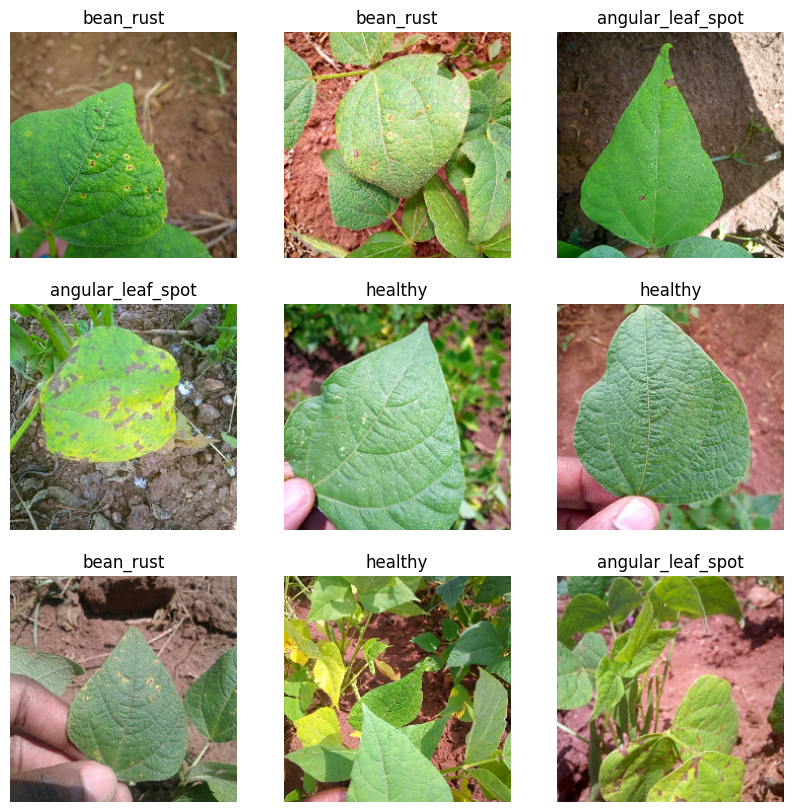

In [25]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [26]:
# Auto tunining the buffer size based batching
# Helps to prefetch and serialize data for the GPU processing

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# Setting the random seed
tf.random.set_seed(111)

In [40]:
# Model build

mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values to range [0,1]
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer(mobilenet_v2)(x)),
    tf.keras.layers.Dropout(0.3),  # Dropout layer with 30% rate
    tf.keras.layers.Dense(3, activation="softmax")  # Output layer
])



In [49]:
# Alternate code for model build
import tensorflow as tf
import tensorflow_hub as hub

# Load the MobileNetV2 model
mobilenet_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer(mobilenet_v2_url, trainable=False)(x)),  # Fixing error
    tf.keras.layers.Dropout(0.3),  # Regularization
    tf.keras.layers.Dense(3, activation="softmax")  # Classification layer
])


In [50]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Display the model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 1001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           3,006 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,006 (11.74 KB)

 Trainable params: 3,006 (11.74 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3734 - loss: 1.7342 - val_accuracy: 0.6917 - val_loss: 0.7589
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6216 - loss: 0.9273 - val_accuracy: 0.7519 - val_loss: 0.6007
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7063 - loss: 0.7266 - val_accuracy: 0.7970 - val_loss: 0.5122
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7773 - loss: 0.5585 - val_accuracy: 0.8346 - val_loss: 0.4460
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7983 - loss: 0.4921 - val_accuracy: 0.8346 - val_loss: 0.4125
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8233 - loss: 0.4803 - val_accuracy: 0.8271 - val_loss: 0.3696
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8123 - loss: 0.4537 - val_accuracy: 0.8496 - val_loss: 0.3453
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8356 - loss: 0.3826 - val_accuracy: 0.8496 - val_loss: 0.3253
E

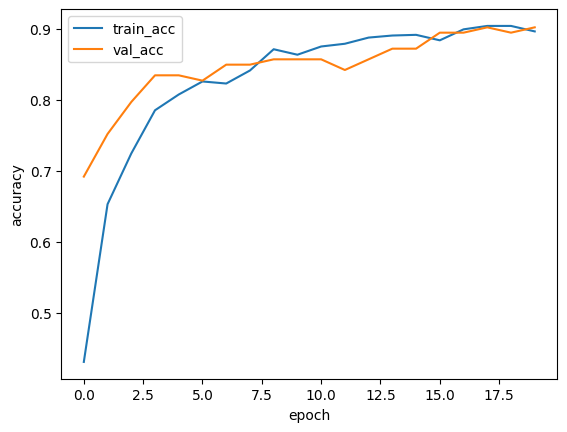

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [53]:
result = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8906 - loss: 0.2846


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


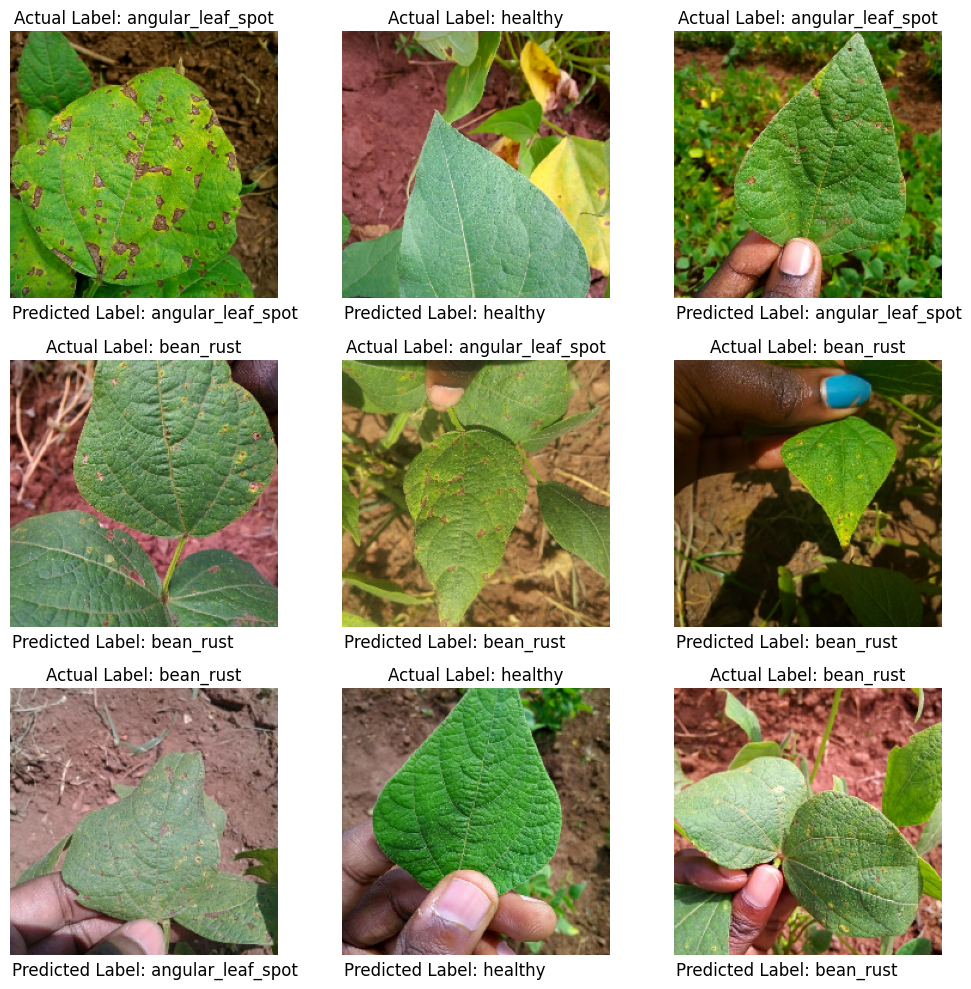

In [54]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)

    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [55]:
# Save model
model.save('./models.keras')

In [56]:
import tensorflow_hub as hub
model_loaded = tf.keras.models.load_model('/content/models.keras', safe_mode=False)

In [57]:
from PIL import Image
from skimage import transform

def process(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')
  np_image = transform.resize(np_image, (224, 224, 3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image

In [45]:
import numpy as np
from PIL import Image
from skimage import transform

def process(filename):
    np_image = Image.open(filename).convert("RGB")  # Ensure RGB format
    np_image = np.array(np_image) / 255.0  # Normalize pixel values to [0,1]
    np_image = transform.resize(np_image, (224, 224, 3))  # Resize to 224x224
    np_image = np.expand_dims(np_image, axis=0)  # Add batch dimension
    return np_image


In [63]:
pred_label= model.predict(process('beans/train/healthy/healthy_train.1.jpg'))
print(classes[np.argmax(pred_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
healthy


In [65]:
!zip -r models.zip models.keras

  adding: models.keras (deflated 38%)


In [64]:
print(tf.__version__)

2.19.0
